# Making a car classifier using Pytorch

In this notebook we construct a car classifier using the Stanford car dataset, which contains 196 classes (said differently, 196 car models).
We will use a pre-trained resnet34 with transfer learning to train the model. 
All layers will be fine tuned and the last fully connected layer will be replaced entirely.

Dataset (196 classes):

Train folder: 8144 images, avg: 41.5 images per class.

Test folder: 8041 images, avg: 41.0 images per class.

## Directory to store the dataset

In [6]:
#where the images from the dataset will be stored 
dataset_root_dir='/mnt/tier1/project/lxp_apps/datasets'

In [7]:
#Copy the json file containing your username and the token from your Kaggle profile
!cp ~/.kaggle/kaggle.json .

## Loading the dataset and making the different imports

In [19]:
import opendatasets as od
import os
# Assign the Kaggle data set URL into variable
dataset_name='stanford-car-dataset-by-classes-folder'
# Using opendatasets let's download the data sets
dataset = os.path.join('https://www.kaggle.com/datasets/jutrera/', dataset_name)
od.download(dataset, data_dir=dataset_root_dir, force=False)

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import time
import PIL.Image as Image
from IPython.display import display

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

Skipping, found downloaded files in "/mnt/tier1/project/lxp_apps/datasets/stanford-car-dataset-by-classes-folder" (use force=True to force download)
cuda:0
NVIDIA A100-SXM4-40GB


## Load the data and transform

First, lets create some transforms for our data and load the train/test data+labels from the folders.

Here we are using 300x300 images with random horizontal flip, random rotation and normalization

In [20]:
dataset_dir = os.path.join(dataset_root_dir,dataset_name, "car_data/car_data/", )
dataset_dir_train = os.path.join(dataset_dir, 'train/')
dataset_dir_test = os.path.join(dataset_dir, 'test/')

if not os.path.isdir(dataset_dir_train):
    os.mkdir(dataset_dir_train)
    
if not os.path.isdir(dataset_dir_test):
    os.mkdir(dataset_dir_test)

In [21]:
train_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(15),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.ImageFolder(root=dataset_dir_train, transform = train_tfms)
trainloader = torch.utils.data.DataLoader(dataset, batch_size = 32, shuffle=True, num_workers = 2)

dataset2 = torchvision.datasets.ImageFolder(root=dataset_dir_test, transform = test_tfms)
testloader = torch.utils.data.DataLoader(dataset2, batch_size = 32, shuffle=False, num_workers = 2)

## Model training function

Here we train our model, after each epoch, we test the model on the test data to see how it's going

In [12]:
def train_model(model, criterion, optimizer, scheduler, n_epochs = 5):
    
    losses = []
    accuracies = []
    test_accuracies = []
    # set the model to train mode initially
    model.train()
    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(trainloader, 0):

            # get the inputs and assign them to cuda
            inputs, labels = data
            #inputs = inputs.to(device).half() # uncomment for half precision model
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # calculate the loss/acc later
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(trainloader)
        epoch_acc = 100/32*running_correct/len(trainloader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_acc = eval_model(model)
        test_accuracies.append(test_acc)
        
        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies

    

### Evaluate on training data
This function is called out after each epoch of training on the training data. We then measure the accuracy of the model.

In [13]:
def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            images, labels = data
            #images = images.to(device).half() # uncomment for half precision model
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model_ft(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (
        test_acc))
    return test_acc

In [17]:
from torchvision.models import resnet34
from torchvision.models.resnet import ResNet34_Weights

# Providing the weights is a way to use a pre-trained model!
weights = ResNet34_Weights.DEFAULT
model_ft = resnet34(weights=weights)


num_ftrs = model_ft.fc.in_features

# replace the last fc layer with an untrained one (requires grad by default)
model_ft.fc = nn.Linear(num_ftrs, 196)
model_ft = model_ft.to(device)

# uncomment this block for half precision model
"""
model_ft = model_ft.half()


for layer in model_ft.modules():
    if isinstance(layer, nn.BatchNorm2d):
        layer.float()
"""
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

"""
probably not the best metric to track, but we are tracking the training accuracy and measuring whether
it increases by atleast 0.9 per epoch and if it hasn't increased by 0.9 reduce the lr by 0.1x.
However in this model it did not benefit me.
"""
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

In [18]:
model_ft, training_losses, training_accs, test_accs = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=10)

Epoch 1, duration: 76 s, loss: 3.9834, acc: 15.5515
Accuracy of the network on the test images: 28 %
Epoch 2, duration: 43 s, loss: 1.6795, acc: 56.5809
Accuracy of the network on the test images: 55 %
Epoch 3, duration: 42 s, loss: 0.8612, acc: 76.9975
Accuracy of the network on the test images: 72 %
Epoch 4, duration: 42 s, loss: 0.5496, acc: 85.5515
Accuracy of the network on the test images: 69 %
Epoch 5, duration: 42 s, loss: 0.3535, acc: 90.3064
Accuracy of the network on the test images: 79 %
Epoch 6, duration: 41 s, loss: 0.2599, acc: 92.7206
Accuracy of the network on the test images: 82 %
Epoch 7, duration: 40 s, loss: 0.1182, acc: 97.0711
Accuracy of the network on the test images: 90 %
Epoch 8, duration: 42 s, loss: 0.0790, acc: 98.3701
Accuracy of the network on the test images: 90 %
Epoch 9, duration: 41 s, loss: 0.0667, acc: 98.7377
Accuracy of the network on the test images: 90 %
Epoch 10, duration: 41 s, loss: 0.0594, acc: 98.8113
Accuracy of the network on the test im

### As we can see the model reached 90% training accuracy by epoch 10.


Text(0.5, 1.0, 'Test acc')

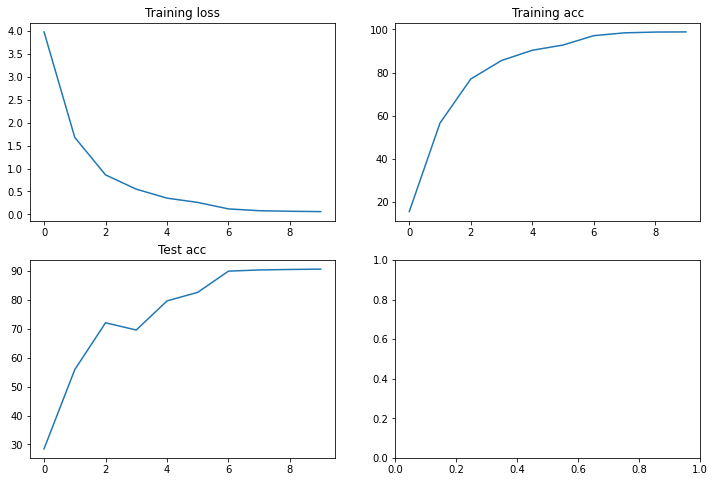

In [22]:
# plot the stats

f, axarr = plt.subplots(2,2, figsize = (12, 8))
axarr[0, 0].plot(training_losses)
axarr[0, 0].set_title("Training loss")
axarr[0, 1].plot(training_accs)
axarr[0, 1].set_title("Training acc")
axarr[1, 0].plot(test_accs)

axarr[1, 0].set_title("Test acc")

### Evaluate the model on single images (e.g for production)

Next we can use the model on our own images. For that we need to tie the class numbers for which the model returns probablities with the names of those classes.


In [23]:
# tie the class indices to their names

def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, c_to_idx = find_classes(dataset_dir+"train")

In [24]:
# test the model on random images


# switch the model to evaluation mode to make dropout and batch norm work in eval mode
model_ft.eval()

# transforms for the input image
loader = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
image = Image.open(dataset_dir+"test/Mercedes-Benz C-Class Sedan 2012/01977.jpg")
image = loader(image).float()
image = torch.autograd.Variable(image, requires_grad=True)
image = image.unsqueeze(0)
image = image.cuda()
output = model_ft(image)
conf, predicted = torch.max(output.data, 1)

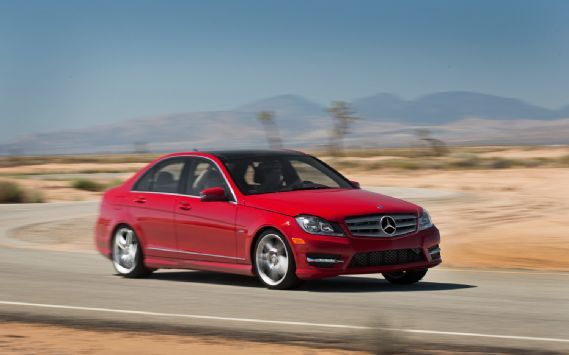

Mercedes-Benz C-Class Sedan 2012 confidence:  14.44410514831543


In [25]:
# get the class name of the prediction
display(Image.open(dataset_dir+"test/Mercedes-Benz C-Class Sedan 2012/01977.jpg"))
print(classes[predicted.item()], "confidence: ", conf.item())

In [32]:
!wget 'https://www.netcarshow.com/Mercedes-Benz-C-Class-2012-1600-02.jpg'

--2024-03-12 14:08:10--  https://www.netcarshow.com/Mercedes-Benz-C-Class-2012-1600-02.jpg
Resolving www.netcarshow.com (www.netcarshow.com)... 208.117.9.16
Connecting to www.netcarshow.com (www.netcarshow.com)|208.117.9.16|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-03-12 14:08:11 ERROR 404: Not Found.



In [35]:
!curl https://www.netcarshow.com/Mercedes-Benz-C-Class-2012-1600-02.jpg -o ${PWD}/Mercedes-Benz-C-Class-2012.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   138  100   138    0     0    425      0 --:--:-- --:--:-- --:--:--   425


In [34]:
os.getcwd()

'/mnt/tier2/users/mmagliulo/PyTorch_models'

In [36]:
!ls

kaggle.json			pytorch-car-classifier-90-accuracy.ipynb
Mercedes-Benz-C-Class-2012.jpg


In [38]:
image_dl_path=os.path.join(os.getcwd(), 'Mercedes-Benz-C-Class-2012.jpg')
assert os.path.isfile(image_dl_path)

In [39]:
image = Image.open(image_dl_path)
image = loader(image).float()
image = torch.autograd.Variable(image, requires_grad=True)
image = image.unsqueeze(0)
image = image.cuda()
output = model_ft(image)
conf, predicted = torch.max(output.data, 1)

UnidentifiedImageError: cannot identify image file '/mnt/tier2/users/mmagliulo/PyTorch_models/Mercedes-Benz-C-Class-2012.jpg'

In [41]:
!realpath Mercedes-Benz-C-Class-2012.jpg

/mnt/tier2/users/mmagliulo/PyTorch_models/Mercedes-Benz-C-Class-2012.jpg
